In [1]:
from ipywidgets import widgets
from IPython.display import Image
from IPython.display import display, HTML

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib notebook

import pathlib
import warnings
import pickle

from IPython.display import display, Markdown

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

from wms.dbs import pit, csv, weadbs, preferences
from wms.analysis import classification as clf

from wms.dbs.csv import nbatct as nbct
from wms.defects import asym, maxslope

Using bladecontrol plotting style.
Registering webvis-style.


# Check asymmetry for CtR sensors

In [4]:
stvars = ['azimuth_mean', 'azimuth_sigma', 'omega_mean', 'omega_sigma', 
          'pitch_mean', 'pitch_sigma', 'power_mean', 'power_sigma',
          'temperature_mean', 'wind_mean', 'wind_sigma']

In [5]:
def plot_labels(db, cycinfo, isdefect, channel, metric, y='wind_mean', ax=None):
    cycinfo = cycinfo.loc(db)
    isdefect = isdefect.loc(db)
    
    if ax is None:
        _, ax = plt.subplots()
    
    data = cycinfo.st[y] if y in cycinfo.st else cycinfo.se[(channel, metric)]
    ax = data.plot(lw=1, color='0.6', label=metric if y is None else y, ax=ax)
    
    if y is None:
        if metric == 'maxslope':
            ax.set_yscale('log')
        ax.set_ylabel(metric)
    else:
        ax.set_ylabel(y)
        
    data[isdefect.se[(channel, metric)] == 1].plot(
        ax=ax, style='.k', label='defect')
    data[isdefect.se[(channel, metric)] == 0].plot(
        ax=ax, style='.', color='tab:cyan', label='normal')
    
    ax.set_title(f'{db}\n{metric} defect labels for {channel}')
    ax.get_figure().tight_layout()
    
    return ax


def nbct(db, ct, nb=1, days=1):
    ct = pd.Timestamp(ct)
    
    if nb == 0:
        return ct
    elif nb > 0:
        cts = weadbs.cdef_query(
            db, cycle='hour', where={
                'create_time': (ct + pd.Timedelta(minutes=1), ct + pd.Timedelta(days=days)),
                'available_data': {2, 3}},
            columns=['create_time', 'ID', 'available_data'])
    else:
        nb = -nb
        cts = weadbs.cdef_query(
            db, cycle='hour', where={
                'create_time': (ct - pd.Timedelta(days=days), ct),
                'available_data': {2, 3}},
            columns=['create_time', 'ID', 'available_data']).sort_index(ascending=False)
    
    if cts.empty:
        return pd.NaT
    
    atcts = cts[cts.available_data == 3]
    if not atcts.empty:
        if nb <= atcts.shape[0]:
            return atcts.create_time.iloc[nb - 1]
        else:
            return pd.NaT
    
    nextat = pd.NaT
    for cycle in cts.itertuples():
        at = csv.load_at_dir(db, cycle.create_time, cycle.ID, oris=['edge'], blades=[1])
        if not at.empty:
            nb -= 1
            if nb == 0:
                nextat = cycle.create_time
                break
    
    return nextat


def check_at(cycinfo, db, ct, ori='edge', blades=(1, 2, 3), with_diff=True,
             labelmetrics=['maxslope', 'asym95_m0std1_split'], fig=None, axes=None):
    st = weadbs.cdef_query(db, cycle='hour', where={'create_time': ct},
                           columns=stvars + ['create_time', 'ID']).loc[0]
    
    tdata = csv.load_at_dir(db, ct, int(st.ID),
                            oris=(ori,) if isinstance(ori, str) else ori, 
                            blades=blades).astype(float)
    if tdata.empty:
        print('No AT-data!')
        return axes
    
    if cycinfo.se.index.nlevels == 2:
        cycinfo = cycinfo.loc(db)
    try:
        metrics = cycinfo.se.loc[ct]
    except KeyError:
        metrics = None
        
    stinfo = (f'\nomega = {st.omega_mean:.3f}, power = {st.power_mean:.0f}, '
              f'pitch = {st.pitch_mean:.0f}, wind = {st.wind_mean:.1f}')
    
    if axes is None:
        if fig is None:
            fig, _ = plt.subplots(
                1 + with_diff, 1, sharex=True, figsize=(7.8, 7 if with_diff else 5),
                squeeze=False)
        else:
            if fig.axes:
                for ax in fig.axes[:1 + with_diff]:
                    ax.clear()
            else:
                axes = fig.subplots(
                    1 + with_diff, 1, sharex=True, squeeze=False)
        
        axes = fig.axes
        
    ax = axes[0]
    ax = tdata.plot(lw=1, ax=ax)
    
    ax.set_title(f'{db} - {ct}{stinfo}')
    
    legend = []
    for ch in tdata.columns:
        label = ch
        if metrics is not None:
            label = f'{label}: ' + ', '.join(
                [f'{m:.2f}' for m in metrics.xs(ch)[labelmetrics]])
        legend.append(label)
    ltitle = '' if metrics is None else '\n'.join(labelmetrics)
            
    ax.set_ylabel('amplitude (digits)')
    
    if with_diff:
        ax = tdata.diff().plot(lw=1, ax=axes[1])
        ax.set_ylabel('diff (digits)')
    
    ax.legend(legend, title=ltitle)
        
    fig.tight_layout()
    
    return axes


def check_af(cycinfo, db, ct, ori='edge', blades=(1, 2, 3), fband=(2, 10), log=False,
             fig=None, ax=None):
    if cycinfo.st.index.nlevels == 2:
        cycinfo = cycinfo.loc(db)
    try:
        st = cycinfo.st.loc[ct]
    except KeyError:
        st = weadbs.cdef_query(db, cycle='hour', where={'create_time': ct},
                               columns=stvars + ['create_time', 'ID']).loc[0]
        
    stinfo = (f'\nomega = {st.omega_mean:.3f}, power = {st.power_mean:.0f}, '
              f'pitch = {st.pitch_mean:.0f}, wind = {st.wind_mean:.1f}')
    
    if ax is None:
        if fig is None:
            fig, ax = plt.subplots(constrained_layout=True)
        else:
            if fig.axes:
                ax = fig.axes[0]
                ax.clear()
            else:
                ax = fig.subplots()
    
    af = csv.load_af(db, ct, int(st.ID), chform='{blade}_{ori}',
                     oris=(ori,) if isinstance(ori, str) else ori, blades=blades)
    
    if not af.empty:
        af = af.unstack('channel').loc[slice(*fband)].sort_index(axis=1)
        af.loc[slice(*fband)].plot(ax=ax)

        ax.set_title(f'{db} - {ct}{stinfo}')
        ax.set_ylabel('amplitude (digits)')

        if log:
            ax.set_yscale('log')
            ax.set_ylim(af.stack().min(), ax.get_ylim()[1])
    
    return ax

### Load precompiled data and information

#### Precalculated metrices

In [6]:
cycpath = 'defect_metrics_acc_normal__since2014_v4.h5'

In [7]:
with pd.HDFStore(cycpath, 'r') as store:
    _, ctrdbs, _ = next(store.walk())
    ctrdbs = pd.Index(ctrdbs, name='dbname')
    
options = pd.read_hdf(cycpath, 'options').to_dict()
where_data = eval(pd.read_hdf(cycpath, 'where')['where'])
    
cycinfo = weadbs.SEData.concat(
    [weadbs.SEData.from_hdf(cycpath, prefix=db) for db in ctrdbs],
    keys=ctrdbs)

In [8]:
cycinfo

signal energies for channels:
[101_edge, 101_flap, 102_edge, 102_flap, 103_edge, 103_flap]
from ('cmrblba_bc_t_00916', Timestamp('2017-04-04 03:19:32')) to ('cmrblba_vst_edf_16209', Timestamp('2020-09-19 09:46:20'))
8798 rows

#### Infos about turbines and tickets

In [9]:
df_tickets = pd.read_pickle("df_tickets.pkl")
df_tickets

,ticket_id,created,first_occurrence,title,description,status,fixed,closed,farm,turbine,db,turbine_type,operational,defect_times,defecttype
0,201601-058,2016-01-08,2016-01-08 14:08:00,"RBL1 edge defekt, Sensorkurzschluss",https://webvis.bladecontrol.de/WebVis/webana?d...,erledigt,2018-10-31 00:00:00,2018-11-01 00:00:00.000,Haiger-Dillbrecht,Vestas 209232,cmrblba_bc_t_01398,Vestas V112/3000 Mk1B,2016-01-08,"{'101_edge': [(2016-01-08 14:08:00,)]}",short_circuit
1,201903-047,2019-03-07,2019-02-21 08:00:00,"RBL2 edge kurzzeitige Unterbrechungen, EMV-Pro...","RBL2 edge sehr kurzzeitige Unterbrechungen, IN...",erledigt,2019-08-23 08:11:00,2019-10-10 00:00:00.000,Johnston,Vensys 227,cmrblba_bc_t_02706,Vensys 3MW/120,2019-03-01,"{'102_edge': [(2019-02-21 08:00:00, 2019-08-23...",short_circuit
2,201909-001,2019-09-02,2019-08-10 00:00:00,RBL2 flap ztw.def. Kurzschluss,RBL2 flap ztw.def. Kurzschluss\r\nBCA423 (R929...,in Bearbeitung,NaT,NaT,Homberg,Vestas 219590,cmrblba_bc_t_02859,Vestas V126/3450 Mk2C,2018-12-19,"{'102_flap': [(2019-08-10 00:00:00,)]}",short_circuit
3,202003-131,2020-03-16,2020-03-14 10:39:00,"RBL2 flap, Sensorkurzschluss","RBL2 flap, Sensorkurzschluss\r\nSensor BCA403b...",in Bearbeitung,NaT,NaT,Bottrop,FWT D 025,cmrblba_bc_t_01571,FWT 3000,2016-10-25,"{'102_flap': [(2020-03-14 10:39:00,)]}",short_circuit
4,202003-150,2020-03-18,2020-03-17 09:47:00,RBL2 flap ztw. Sensorkurzschluss,"RBL2 Sensorkurzschluss, siehe Mail\r\nBCA403b ...",in Bearbeitung,NaT,NaT,Emmendorf,Vestas 16209,cmrblba_vst_edf_16209,Vestas V80-2MW,2011-06-10,"{'102_flap': [(2020-03-17 09:47:00,)]}",short_circuit
0,201508-038,2015-08-10,2015-08-10 11:05:00,"RBL3 edge def., wahrscheinlich Feuchtigkeit/Ko...",RBL3 edge def.,erledigt,2017-09-02 00:00:00,2017-09-05 00:00:00.000,Global Tech I,Adwen GT28,cmrblba_mb_av_028,ADWEN M5000 - 116,2015-05-07,"{'103_edge': [(2015-08-10 11:05:00, 2017-02-09...",corrosion
1,201605-202,2016-05-31,2016-05-30 00:27:00,RBL2 edge/flap def.,"RBL2 edge/flap def., Temp i.o.\r\n\r\nSensor.B...",erledigt,2018-01-12 11:56:00,2018-01-12 00:00:00.000,Rehborn,GE 28130057,cmrblba_bc_t_00920,GE 2.5-120,2014-08-11,"{'102_edge': [(2016-05-30 00:27:00, 2018-01-12...",corrosion
2,201801-093,2018-01-08,2018-01-07 19:47:00,RBL2 flap + Temp defekt,None,erledigt,2018-03-07 15:27:00,2018-03-07 15:35:10.167,Rehborn,GE 28130058,cmrblba_bc_t_00918,GE 2.5-120,2014-08-11,"{'102_flap': [(2018-01-07 19:47:00, 2018-03-07...",corrosion
3,201801-406,2018-01-31,2018-01-27 21:09:00,RBL3 edge+flap+temp defekt,RBL3 edge+flap+temp defekt\r\n\r\nkeine Gewitt...,erledigt,2018-03-14 15:03:00,2018-03-14 15:05:04.077,Medard,GE 28130159,cmrblba_bc_t_01010,GE 2.5-120,2014-10-20,"{'103_edge': [(2018-01-27 21:09:00, 2018-03-14...",corrosion
4,201802-042,2018-02-06,2018-02-05 08:30:00,RBL2 edge/flap defekt,None,erledigt,2018-03-14 15:01:00,2018-10-11 00:00:00.000,Medard,GE 28130159,cmrblba_bc_t_01010,GE 2.5-120,2014-10-20,"{'102_edge': [(2018-02-05 08:30:00, 2018-03-14...",corrosion


#### Load turbine infos of turbines contained in precalculated metrics data

In [10]:
weainfo = pit.query_pit(
    f"""SELECT Datenbankname, WEA_Typ#Name, WEA_Name, Windpark_WEA#Windparkname
        FROM VIEW_Windkraftanlagen 
        WHERE Datenbankname in ({', '.join(['%s'] * ctrdbs.size)})""",
    tuple(ctrdbs)).set_index('Datenbankname')

weainfo['N'] = cycinfo.se.groupby(level='dbname').size()
weainfo

,WEA_Typ#Name,WEA_Name,Windpark_WEA#Windparkname,N
Datenbankname,,,,
cmrblba_vst_edf_16209,Vestas V80-2MW,Vestas 16209,Emmendorf,842
cmrblba_mb_gt_025,ADWEN M5000 - 116,Adwen GT25,Global Tech I,511
cmrblba_mb_av_028,ADWEN M5000 - 116,Adwen GT28,Global Tech I,203
cmrblba_bc_t_00920,GE 2.5-120,GE 28130057,Rehborn,732
cmrblba_bc_t_00918,GE 2.5-120,GE 28130058,Rehborn,1189
cmrblba_ge_rbn_00907,GE 2.5-120,GE 28130056,Rehborn,540
cmrblba_bc_t_00916,GE 2.5-120,GE 28130052,Rehborn,616
cmrblba_bc_t_01010,GE 2.5-120,GE 28130159,Medard,1064
cmrblba_bc_t_01398,Vestas V112/3000 Mk1B,Vestas 209232,Haiger-Dillbrecht,1427


### Display infos about precalculated metrices

In [11]:
data = cycinfo.se
#data = cycinfo.select_st().se.stack('channel')
data.tail()

channel                                        101_edge                      \
start_f                                   asym95_m0std1 asym95_m0std1_split   
dbname                create_time                                             
cmrblba_vst_edf_16209 2020-09-05 09:44:13      0.063645            0.752516   
                      2020-09-07 09:41:43      0.046330            0.782441   
                      2020-09-12 09:42:43      0.007116            0.788837   
                      2020-09-16 09:40:22      0.210698            0.206840   
                      2020-09-19 09:46:20      0.035124            0.898482   

channel                                                                  \
start_f                                   asym95_std1  max_amp maxslope   
dbname                create_time                                         
cmrblba_vst_edf_16209 2020-09-05 09:44:13    0.016036  20054.0   2172.0   
                      2020-09-07 09:41:43    0.032491  19499.0    772.0   
                      2020-09-12 09:42:43    0.014730  20084.0   1270.0   
                      2020-09-16 09:40:22    0.192246   1257.0    234.0   
                      2020-09-19 09:46:20    0.029301  19496.0   2231.0   

channel                                                      101_flap  \
start_f                                              se asym95_m0std1   
dbname                create_time                                       
cmrblba_vst_edf_16209 2020-09-05 09:44:13  5.255613e+06      0.002969   
                      2020-09-07 09:41:43  5.195706e+06      0.086850   
                      2020-09-12 09:42:43  5.213368e+06      0.084149   
                      2020-09-16 09:40:22  4.220128e+05      0.179220   
                      2020-09-19 09:46:20  5.318626e+06      0.026183   

channel                                                                    \
start_f                                   asym95_m0std1_split asym95_std1   
dbname                create_time                                           
cmrblba_vst_edf_16209 2020-09-05 09:44:13            0.700699    0.032316   
                      2020-09-07 09:41:43            0.528524    0.118184   
                      2020-09-12 09:42:43            0.564201    0.069551   
                      2020-09-16 09:40:22            0.144475    0.063930   
                      2020-09-19 09:46:20            0.648509    0.038651   

channel                                            ...    103_edge           \
start_f                                   max_amp  ... asym95_std1  max_amp   
dbname                create_time                  ...                        
cmrblba_vst_edf_16209 2020-09-05 09:44:13  7530.0  ...    0.004469  20595.0   
                      2020-09-07 09:41:43  6666.0  ...    0.006598  19895.0   
                      2020-09-12 09:42:43  7615.0  ...    0.018644  20467.0   
                      2020-09-16 09:40:22  1594.0  ...    0.023830   1575.0   
                      2020-09-19 09:46:20  7366.0  ...    0.006943  20238.0   

channel                                                           \
start_f                                   maxslope            se   
dbname                create_time                                  
cmrblba_vst_edf_16209 2020-09-05 09:44:13    635.0  5.255613e+06   
                      2020-09-07 09:41:43    880.0  5.195706e+06   
                      2020-09-12 09:42:43    649.0  5.213368e+06   
                      2020-09-16 09:40:22    221.0  4.220128e+05   
                      2020-09-19 09:46:20    533.0  5.318626e+06   

channel                                        103_flap                      \
start_f                                   asym95_m0std1 asym95_m0std1_split   
dbname                create_time                                             
cmrblba_vst_edf_16209 2020-09-05 09:44:13      0.105714            0.381790   
                      2020-09-07 09:41:43      0.045965            0.5

In [21]:
# function to label the time series of df on behalf of the defect periods given in dict_tickets, it returns the indices of that data sets that are within the sensor defect times
def label_metrics_data(cycinfo, df_tickets):
    #sfmt = '%Y-%m-%d %H:%M:%S'
    res = dict()
    res_ix_list = list()
    for idx, row in df_tickets.iterrows():
        db = row['db']
        ticket_id = row['ticket_id']
        defect_times = row['defect_times']  
        
        data = cycinfo.loc(db).se.drop_duplicates().index
        
        for ch, pers in defect_times.items():
            ixs = list()
            for per in pers:
                if len(per)==1:
                    cts = (data[data >= per[0]])
                else:
                    cts = (data[(data >= per[0]) & (data<per[1])])
                ixs.append(cts)
                [res_ix_list.append((db, ct, ch)) for ct in cts]
            res.update({(db, ch): ixs})
            
    res_ix = pd.MultiIndex.from_tuples(res_ix_list, names=['dbname', 'create_time', 'channel'])
    return res, res_ix

In [23]:
dict_defect_times, idx_defect_times = label_metrics_data(cycinfo, df_tickets)
#dict_defect_times

In [24]:
dict_defect_times

{('cmrblba_bc_t_01398',
  '101_edge'): [DatetimeIndex(['2017-03-08 20:40:10', '2017-03-10 20:46:04',
                 '2017-03-12 20:48:51', '2017-03-15 20:39:14',
                 '2017-03-17 20:43:09', '2017-03-19 20:35:57',
                 '2017-03-22 20:36:37', '2017-03-24 20:45:20',
                 '2017-03-26 20:42:25', '2017-03-29 20:33:52',
                 ...
                 '2021-03-18 04:26:56', '2021-03-18 05:58:28',
                 '2021-03-18 05:59:32', '2021-03-18 07:44:44',
                 '2021-03-18 07:45:48', '2021-03-19 20:45:40',
                 '2021-03-20 04:32:16', '2021-03-20 04:33:20',
                 '2021-03-22 22:41:42', '2021-03-22 22:42:46'],
                dtype='datetime64[ns]', name='create_time', length=1427, freq=None)],
 ('cmrblba_bc_t_02706',
  '102_edge'): [DatetimeIndex(['2019-02-21 10:14:34', '2019-02-23 07:39:51',
                 '2019-02-25 07:31:09', '2019-02-27 07:37:13',
                 '2019-03-02 03:18:06', '2019-03-02 07:46:21

## Histograms

### By sensor orientation and operational state

In [25]:
# only start at 3 m/s wind, because we anyway won't be able 
# to detect ice for lower wind
# exclude trudeln for now by selecting high pitch
where_stand = weadbs.Where(
    {'omega_mean': 0, 
     'power_mean': (-500, 1), 
     'wind_mean': (3,),
     'pitch_mean': (40,)})

where_betrieb = weadbs.Where(
    {'omega_mean': (0.05,),
     'power_mean': (1,),
     'wind_mean': (3,)})

def make_bins(opts):
    
    if 'xmax' in opts:
        # original version
        #opts.setdefault(
        #    'bins', np.r_[np.linspace(0, opts['xmax'], opts['B']), 10000])
        
        # modified by CK, otherwise error occurs if xmax>10000
        tmp = opts['xmax']
        if tmp<10000:
            u = 10000
        else:
            u = np.power(10, int(np.ceil(np.log10(tmp))+2))
        opts.setdefault(
            'bins', np.r_[np.linspace(0, opts['xmax'], opts['B']), u]) 
        opts.setdefault('xlim', opts['xmax'] * 1.1)
    else:
        opts.setdefault('bins', opts['B'])

def metric_hist(cycinfo, metric, standopts={}, betriebopts={}, isdefect=None, figsize=(7.8, 6)):
    standopts = standopts.copy()
    standopts.setdefault('where', where_stand)
    standopts.setdefault('B', 100)
    standopts.setdefault('maxslopethr', 100)
    make_bins(standopts)
    
    betriebopts = betriebopts.copy()
    betriebopts.setdefault('where', where_betrieb)
    betriebopts.setdefault('B', 100)
    betriebopts.setdefault('maxslopethr', 800)
    make_bins(betriebopts)
    
    fig, axes = plt.subplots(
        2, 2, sharex='col', sharey='col', constrained_layout=True, figsize=figsize)
    
    for ori, row in zip(['edge', 'flap'], axes):
        data = cycinfo.select_st(standopts['where'], ori).se.stack('channel')
        if isdefect is not None:
            ind = isdefect.select_st(standopts['where'], ori).se.stack(
                'channel')['true'].astype(bool)
        elif 'maxslopethr' in standopts:
            ind = data['maxslope'] > standopts['maxslopethr']
        else:
            ind = None
        
        if ind is not None:
            ax = sns.distplot(
                data.loc[ind, metric], kde=False, bins=standopts['bins'],
                ax=row[0], label='defect')
            ax = sns.distplot(
                data.loc[~ind, metric], kde=False, bins=standopts['bins'],
                ax=row[0], label='normal')
            
            ax.legend(title='maxslope' if isdefect is None else 'true label')
        else:
            ax = sns.distplot(
                data[metric], kde=False, bins=standopts['bins'], ax=row[0])
        
        ax.set_ylabel(f'{ori}\ncycle count')
        
        data = cycinfo.select_st(betriebopts['where'], ori).se.stack('channel')
        if isdefect is not None:
            ind = isdefect.select_st(betriebopts['where'], ori).se.stack(
                'channel')['true'].astype(bool)
        elif 'maxslopethr' in betriebopts:
            ind = data['maxslope'] > betriebopts['maxslopethr']
        else:
            ind = None
        
        if ind is not None:
            ax = sns.distplot(
                data.loc[ind, metric], kde=False, bins=betriebopts['bins'],
                ax=row[1], label='defect')
            ax = sns.distplot(
                data.loc[~ind, metric], kde=False, bins=betriebopts['bins'],
                ax=row[1], label='normal')
            
            ax.legend(title='maxslope' if isdefect is None else 'true label')
        else:    
            ax = sns.distplot(
                data[metric], kde=False, bins=betriebopts['bins'], ax=row[1])
        
    for ax in axes[0, :]:
        ax.set_xlabel('')
        
    axes[0, 0].set_title('stand')
    axes[0, 1].set_title('betrieb')
    if 'xlim' in standopts:
        axes[0, 0].set_xlim(0, standopts['xlim'])
    if 'xlim' in betriebopts:
        axes[0, 1].set_xlim(0, betriebopts['xlim'])
    
    return axes


# new variant 2021-3-18, defect/ok as parameter, not determined by max_slope
def metric_hist2(cycinfo, metric, idx_defect_times, standopts={}, betriebopts={}, figsize=(7.8, 6)):
    standopts = standopts.copy()
    standopts.setdefault('where', where_stand)
    standopts.setdefault('B', 100)
    standopts.setdefault('maxslopethr', 100)
    make_bins(standopts)
    
    betriebopts = betriebopts.copy()
    betriebopts.setdefault('where', where_betrieb)
    betriebopts.setdefault('B', 100)
    betriebopts.setdefault('maxslopethr', 800)
    make_bins(betriebopts)
    
    fig, axes = plt.subplots(
        2, 2, sharex='col', sharey='col', constrained_layout=True, figsize=figsize)
    
    for ori, row in zip(['edge', 'flap'], axes):
        data = cycinfo.select_st(standopts['where'], ori).se.stack('channel').drop_duplicates()
                
        if idx_defect_times is not None:
            ind = data.index.intersection(idx_defect_times)
            not_ind = data.index.difference(idx_defect_times)
            ax = sns.distplot(
                data.loc[ind, metric], kde=False, bins=standopts['bins'],
                ax=row[0], label='defect')
            ax = sns.distplot(
                data.loc[not_ind, metric], kde=False, bins=standopts['bins'],
                ax=row[0], label='normal')
            
            ax.legend(title='true label')
        else:
            ax = sns.distplot(
                data[metric], kde=False, bins=standopts['bins'], ax=row[0])
        
        ax.set_ylabel(f'{ori}\ncycle count')
        
        data = cycinfo.select_st(betriebopts['where'], ori).se.stack('channel').drop_duplicates()
        
        if idx_defect_times is not None:
            ind = data.index.intersection(idx_defect_times)
            not_ind = data.index.difference(idx_defect_times)
            ax = sns.distplot(
                data.loc[ind, metric], kde=False, bins=betriebopts['bins'],
                ax=row[1], label='defect')
            ax = sns.distplot(
                data.loc[not_ind, metric], kde=False, bins=betriebopts['bins'],
                ax=row[1], label='normal')
            
            ax.legend(title='true label')
        else:    
            ax = sns.distplot(
                data[metric], kde=False, bins=betriebopts['bins'], ax=row[1])
        
    for ax in axes[0, :]:
        ax.set_xlabel('')
        
    axes[0, 0].set_title('stand')
    axes[0, 1].set_title('betrieb')
    if 'xlim' in standopts:
        axes[0, 0].set_xlim(0, standopts['xlim'])
    if 'xlim' in betriebopts:
        axes[0, 1].set_xlim(0, betriebopts['xlim'])
    
    return axes

In [36]:
histopts = {
    'maxslope': {'standopts': {'xmax': 33000}, 'betriebopts': {'xmax': 33000}},
    #'asym95_std1': {'standopts': {'xmax': 6}, 'betriebopts': {'xmax': 6}},
    #'asym95_m0std1': {'standopts': {'xmax': 6}, 'betriebopts': {'xmax': 6}},
    'asym95_m0std1_split': {'standopts': {'xmax': 3.5}, 'betriebopts': {'xmax': 3.5}},
    'max_amp': {'standopts': {'xmax': 12000}, 'betriebopts': {'xmax': 33000}}#,
    #'se': {'standopts': {'xmax': 1000}, 'betriebopts': {'xmax': 3000}}
}

### maxslope

<IPython.core.display.Javascript object>


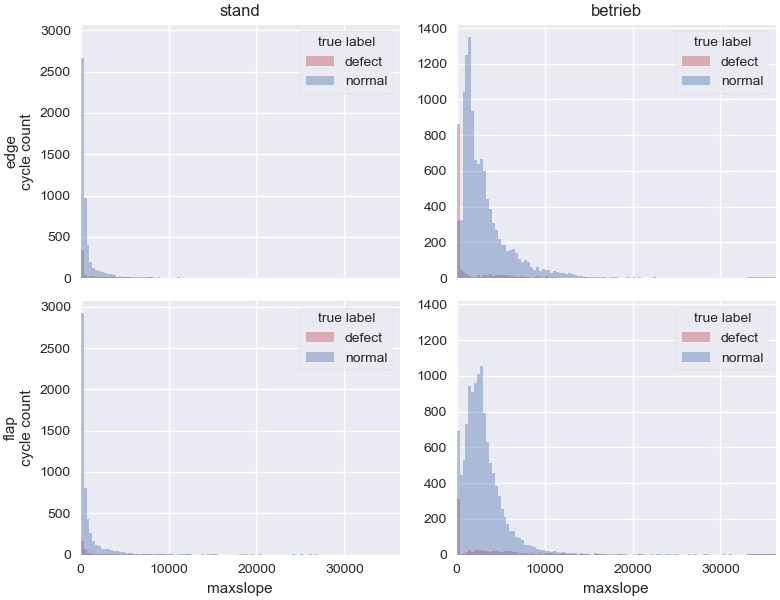

C:\Users\w012028\Miniconda3\envs\sensor_defect\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\w012028\Miniconda3\envs\sensor_defect\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\w012028\Miniconda3\envs\sensor_defect\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

### asym95_m0std1_split

<IPython.core.display.Javascript object>


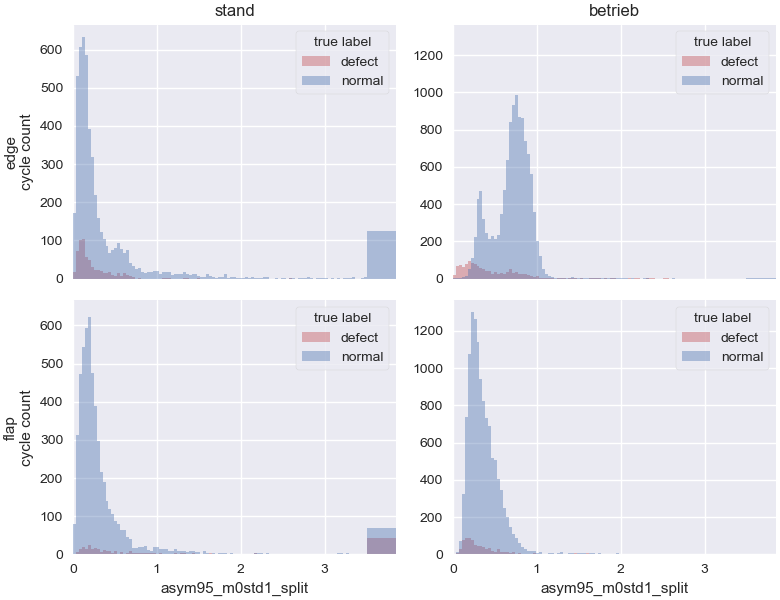

C:\Users\w012028\Miniconda3\envs\sensor_defect\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\w012028\Miniconda3\envs\sensor_defect\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\w012028\Miniconda3\envs\sensor_defect\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

### max_amp

<IPython.core.display.Javascript object>


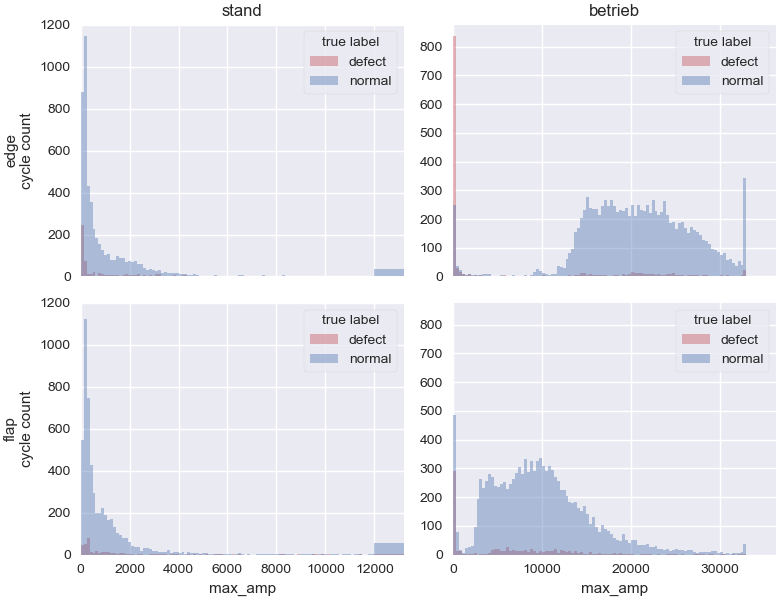

C:\Users\w012028\Miniconda3\envs\sensor_defect\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\w012028\Miniconda3\envs\sensor_defect\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\w012028\Miniconda3\envs\sensor_defect\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

In [37]:
for _metric, _opts in histopts.items():
    display(Markdown('### ' + _metric))
    axes = metric_hist2(cycinfo, _metric, idx_defect_times, **_opts)

## By turbine and channel

In [24]:
chs_edge = ['101_edge', '102_edge', '103_edge']
chs_flap = ['101_flap', '102_flap', '103_flap']
chs_all = np.r_[chs_edge, chs_flap]

In [31]:
def plot_hists_by_db(df_tickets, cycinfo, metric, opwhere=dict(), chs = chs_all, bins=np.r_[np.linspace(0,30000,100), 40000], xlim = [-10, 20000]):

    ctrdbs = df_tickets.db.unique()
    cp = sns.color_palette("Paired")
    cp2 = [cp[i] for i in [5,4,1,0,3,2]]    
    
    fig, axes = plt.subplots(ctrdbs.size, 1, sharex=True, constrained_layout=True,
                             figsize=(9.3, max(4, 2 * ctrdbs.size)))

    for ax, _db in zip(axes, ctrdbs):
        df = df_tickets[df_tickets.db==_db].loc[:, ['defect_times', 'defecttype']]
        for _idx, row in df.iterrows():
            sinfo = ",".join(row['defect_times'].keys()) + f": {row['defecttype']}"
        
        _data = cycinfo.select_st(opwhere).se.loc[_db].xs(metric, axis=1, level=1, drop_level=True).drop_duplicates()
        if not _data.empty:
            sns.histplot(data=_data, ax=ax, kde=True, legend=True, bins=bins, palette = cp2)
            #sns.displot(data=_data, ax=ax, kde=False)#, bins=np.r_[np.linspace(0, 1000, 100), 100000])#, hue=, row=None, col=None, weights=None, kind='hist', rug=False, rug_kws=None, log_scale=None, legend=True, palette=None, hue_order=None, hue_norm=None, color=None, col_wrap=None, row_order=None, col_order=None, height=5, aspect=1, facet_kws=None, **kwargs)¶
#                             bins=np.r_[np.linspace(0, 1000, 100), 10000])

        #ax.legend()
        ax.set_ylabel(_db)
        ax.set_xlabel('')
        ax.set_xlim(xlim)
        ax.set_title(sinfo, y=0.85, fontsize=10)

### max-slope

<IPython.core.display.Javascript object>


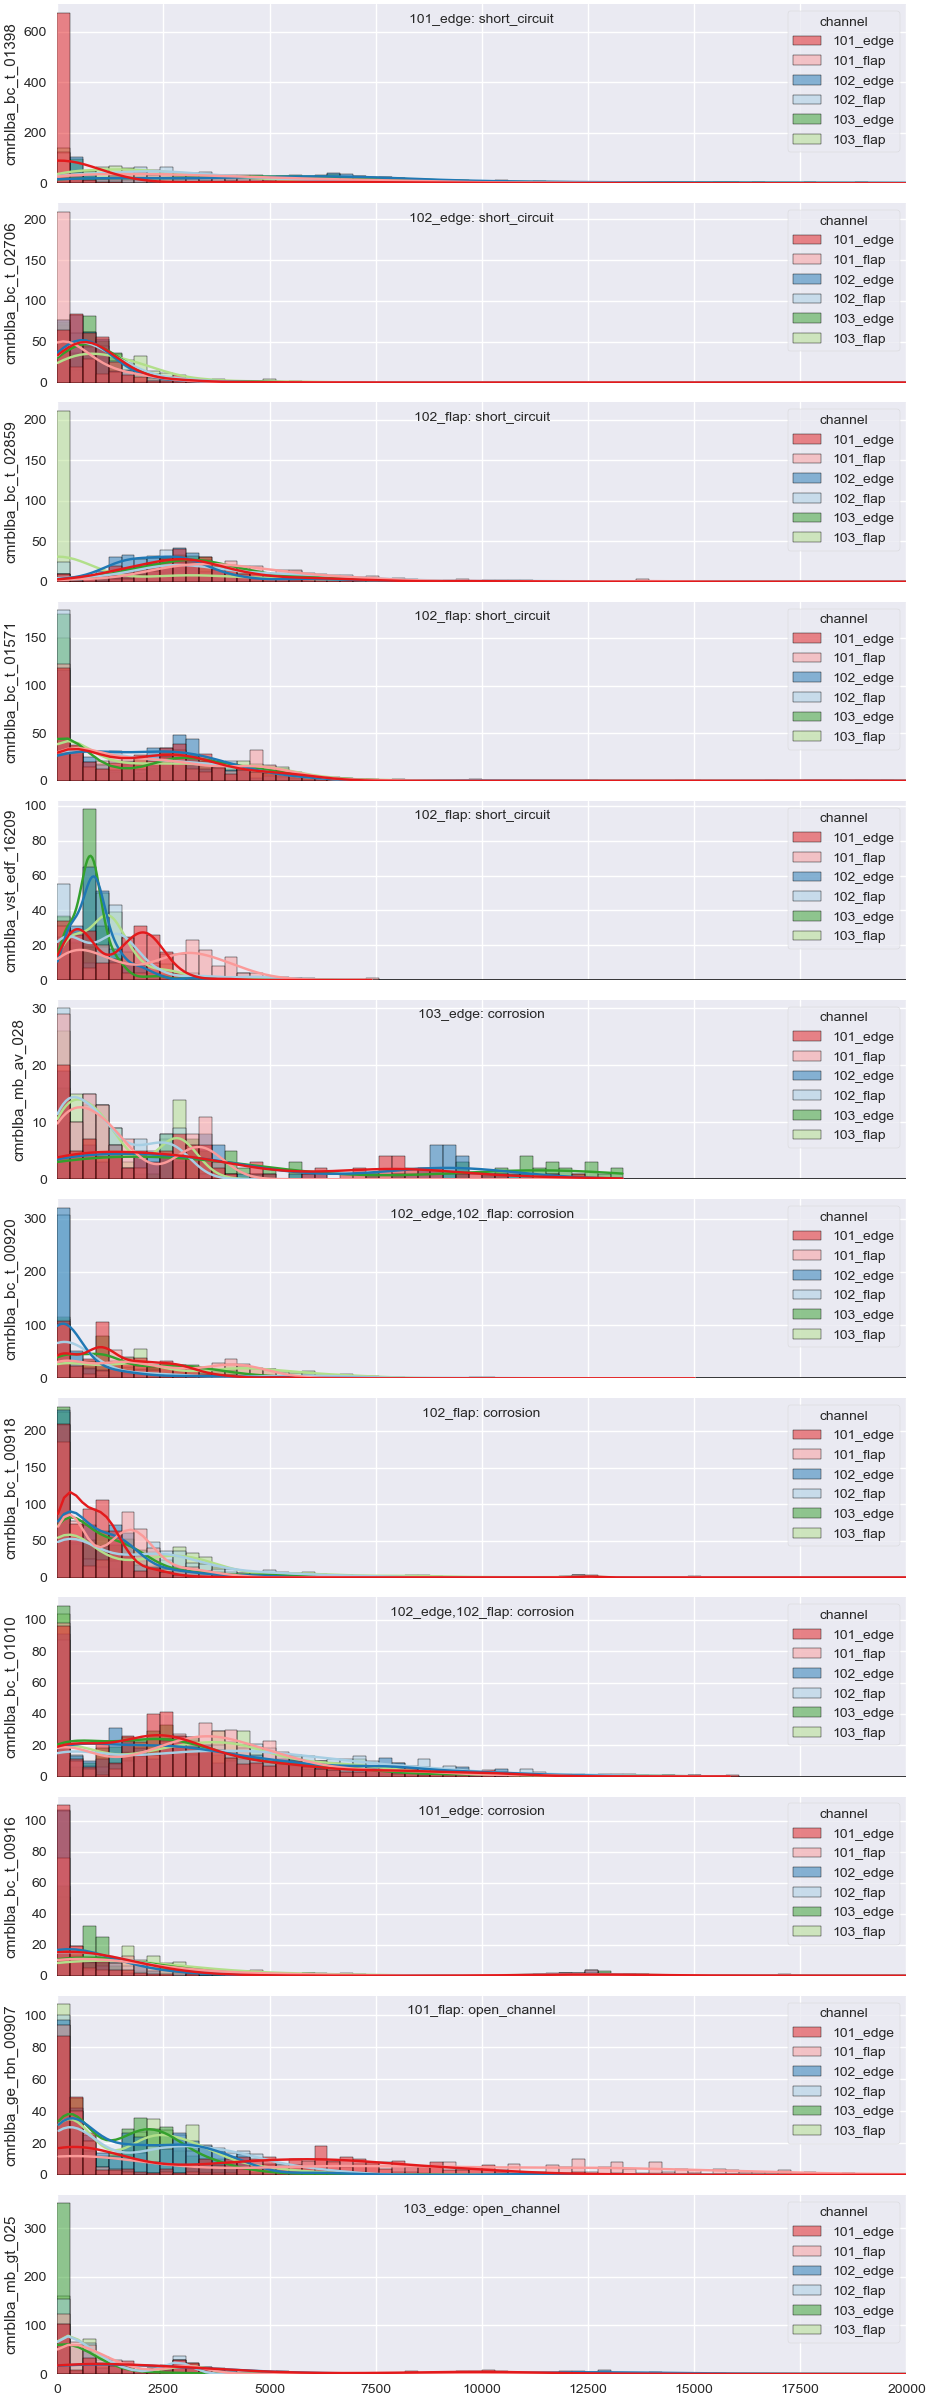

In [32]:
plot_hists_by_db(df_tickets, cycinfo, 'maxslope')

In [ ]:
weitere Darstellungen anfertigen:
    - aufgespalten nach stand/betrieb
    - aufgespalten nach edge/flap 
    - aufgespalten nach defekt/ok

Dabei herausfinden:
    - was sind sinnvolle Schwellwerte fuer Stand und Betrieb, edge und flap
    - uebriggebliebene Defekte nach den jeweils anderen Metriken darstellen

### max amplitude

<IPython.core.display.Javascript object>


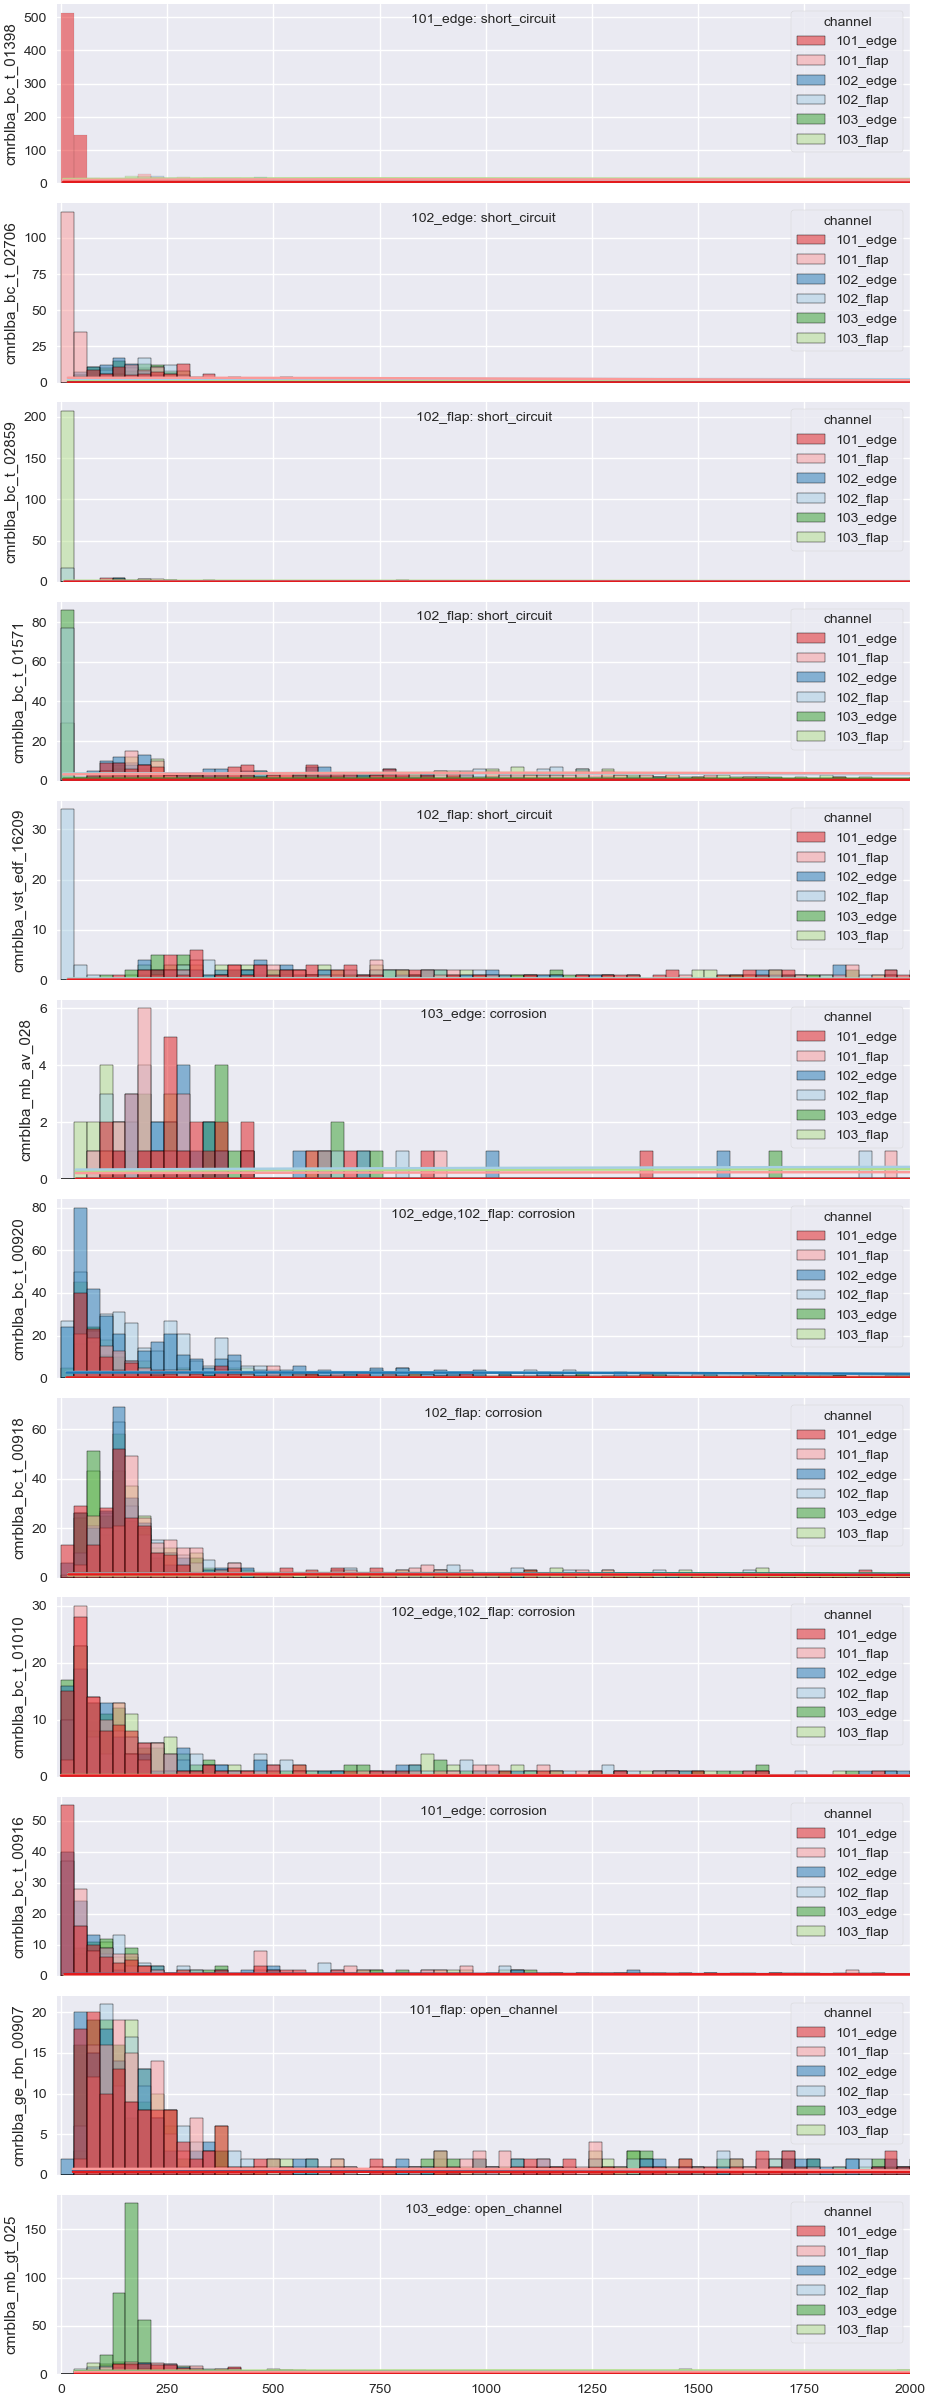

In [34]:
plot_hists_by_db(df_tickets, cycinfo, 'max_amp', bins=np.r_[np.linspace(0,3000,100), 4000], xlim=[-10, 2000])

### asymmetry

<IPython.core.display.Javascript object>


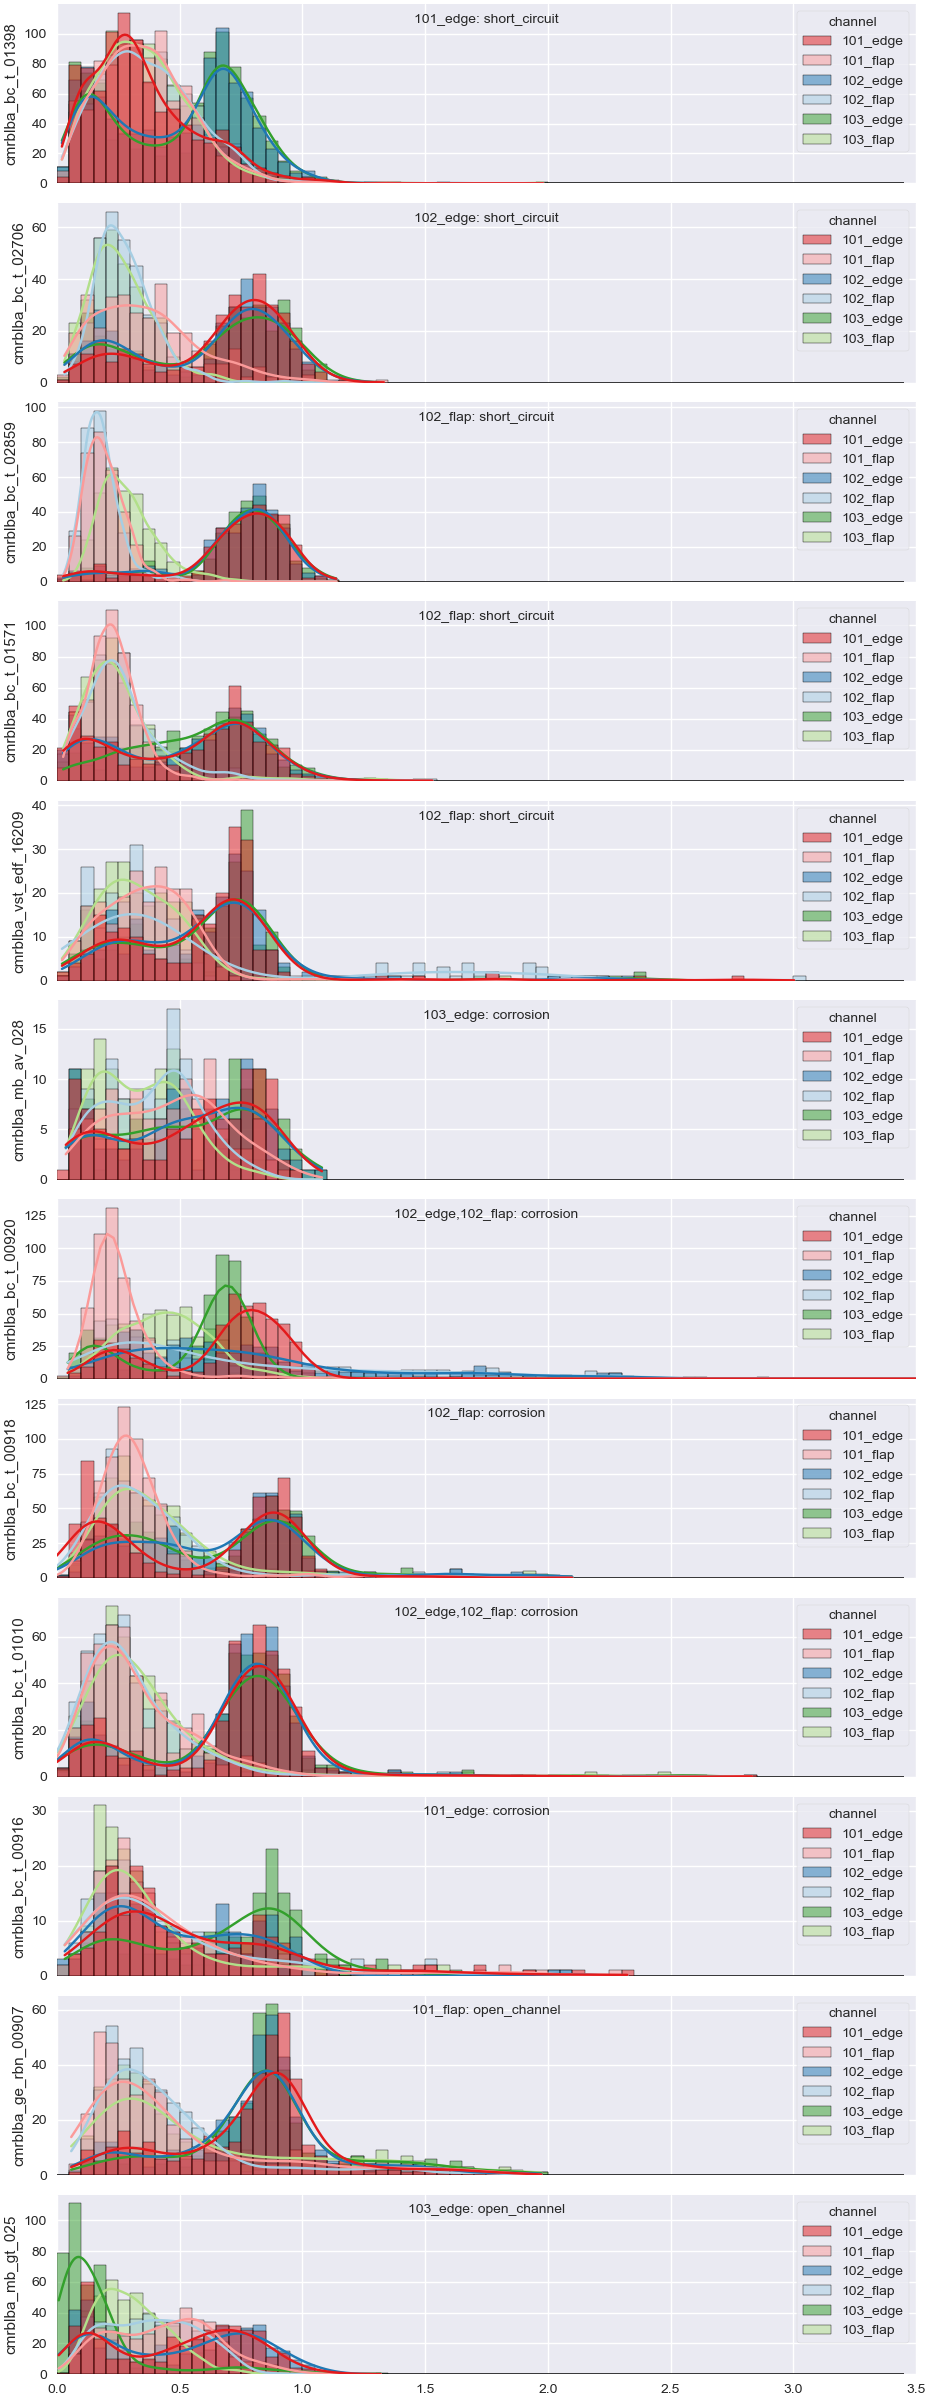

In [35]:
plot_hists_by_db(df_tickets, cycinfo, 'asym95_m0std1_split', bins=np.arange(0, 3.5, 0.05), xlim = [0, 3.5])

TODO:

* inkonsistent aussehende Kanaele durchgehen und weglassen, re-labeln o.ae.
* jeweils 1 Diagramm fuer (stand,betrieb) x (edge,flap) x metrics anfertigen:
    
    * Boxplots fuer ok, kurzschluss, offener kanal usw. nebeneinander darstellen
    * Histogramme fuer ok, Kurzschluss, offener Kanal usw. nebeneinander darstellen
    
* aus unabhaengig voneinander bestimmten Werte F1, false positives etc. fuer jede einzelne Defektform und insgesamt berechnen und darstellen
* pipeline bauen, Parameter in Kombination ermitteln fuer jede WEA einzeln und insgesamt
* mit unabhaengig voneinander ermittelten Parametern vgl.n nebeneinander
* false positives/true negatives getrennt betrachten

In [36]:
# TODO 2021-3-23: alle Daten (se, st, tickest) kombinieren um einen Dataframe mit Betriebszustaenden, Metriken und Defekttyp zu erzeugen fuer einfachere Erstellung von Boxplots etc. Dazu se wide to long, mit st joinen, durch df_tickets durchgehen und ok/Defekttyp eintragen    

(13, 15)

In [38]:
df_tickets.head(2)

,ticket_id,created,first_occurrence,title,description,status,fixed,closed,farm,turbine,db,turbine_type,operational,defect_times,defecttype
0,201601-058,2016-01-08,2016-01-08 14:08:00,"RBL1 edge defekt, Sensorkurzschluss",https://webvis.bladecontrol.de/WebVis/webana?d...,erledigt,2018-10-31 00:00:00,2018-11-01,Haiger-Dillbrecht,Vestas 209232,cmrblba_bc_t_01398,Vestas V112/3000 Mk1B,2016-01-08,"{'101_edge': [(2016-01-08 14:08:00,)]}",short_circuit
1,201903-047,2019-03-07,2019-02-21 08:00:00,"RBL2 edge kurzzeitige Unterbrechungen, EMV-Pro...","RBL2 edge sehr kurzzeitige Unterbrechungen, IN...",erledigt,2019-08-23 08:11:00,2019-10-10,Johnston,Vensys 227,cmrblba_bc_t_02706,Vensys 3MW/120,2019-03-01,"{'102_edge': [(2019-02-21 08:00:00, 2019-08-23...",short_circuit


In [58]:
df_se = cycinfo.se.drop_duplicates().reset_index().head()
print(df_se)
pd.melt(df_se, id_vars='date', value_vars=['AA', 'BB', 'CC'])

channel              dbname         create_time      101_edge  \
start_f                                         asym95_m0std1   
0        cmrblba_bc_t_00916 2017-04-04 03:19:32      0.022500   
1        cmrblba_bc_t_00916 2017-04-06 03:19:40      0.046501   
2        cmrblba_bc_t_00916 2017-04-22 03:18:24      0.024677   
3        cmrblba_bc_t_00916 2017-05-06 03:21:23      0.032860   
4        cmrblba_bc_t_00916 2017-09-02 03:21:26      0.792796   

channel                                                                  \
start_f asym95_m0std1_split asym95_std1  max_amp maxslope            se   
0                  0.971732    0.020951  14911.0   1190.0  4.863913e+06   
1                  0.837349    0.013652  15453.0   1471.0  4.949572e+06   
2                  0.912721    0.023619  17854.0   1562.0  5.744306e+06   
3                  0.658745    0.023425  19798.0   1871.0  6.021091e+06   
4                  0.096153    0.556697     61.0     34.0  3.393207e+04   

channel      101_flap                      ...    103_edge                    \
start_f asym95_m0std1 asym95_m0std1_split  ... asym95_std1  max_amp maxslope   
0            0.079545            0.337026  ...    0.019053  15504.0    686.0   
1            0.057642            0.250753  ...    0.028758  16089.0   1016.0   
2            0.026683            0.257230  ...    0.038015  19279.0   1423.0   
3            0.082386            0.144760  ...    0.045441  20776.0   1761.0   
4            0.771555            0.071663  ...    1.845093    117.0    119.0   

channel                    103_flap                                          \
start_f            se asym95_m0std1 asym95_m0std1_split asym95_std1 max_amp   
0        4.863913e+06      0.024674            0.350528    0.012765  9713.0   
1        4.949572e+06      0.055408            0.232671    0.042388  8418.0   
2        5.744306e+06      0.192528            0.260936    0.191777  7640.0   
3        6.021091e+06      0.223563            0.224992    0.232777  9529.0   
4        3.393207e+04      0.303947            0.093740    0.046069   193.0   

channel                         
start_f maxslope            se  
0         1640.0  4.863913e+06  
1         1520.0  4.949572e+06  
2         2531.0  5.744306e+06  
3         4070.0  6.021091e+06  
4          133.0  3.393207e+04  

[5 rows x 38 columns]

In [50]:
cycinfo.st.head(2)

variable                                   ID  azimuth_mean  azimuth_sigma  \
dbname             create_time                                               
cmrblba_bc_t_00916 2017-04-04 03:19:32  59643           NaN            NaN   
                   2017-04-04 03:19:32  59643           NaN            NaN   

variable                                omega_mean  omega_sigma  pitch_mean  \
dbname             create_time                                                
cmrblba_bc_t_00916 2017-04-04 03:19:32    0.129837      0.82447    0.304419   
                   2017-04-04 03:19:32    0.129837      0.82447    0.304419   

variable                                pitch_sigma  power_mean  power_sigma  \
dbname             create_time                                                 
cmrblba_bc_t_00916 2017-04-04 03:19:32     0.129821    -11.3454      86.0187   
                   2017-04-04 03:19:32     0.129821    -11.3454      86.0187   

variable                                temperature_mean  wind_mean  \
dbname             create_time                                        
cmrblba_bc_t_00916 2017-04-04 03:19:32           10.7604    2.72092   
                   2017-04-04 03:19:32           10.7604    2.72092   

variable                                wind_sigma  
dbname             create_time                      
cmrblba_bc_t_00916 2017-04-04 03:19:32    0.435457  
                   2017-04-04 03:19:32    0.435457

In [42]:
df = cycinfo.se.drop_duplicates().merge(cycinfo.st.drop_duplicates(), left_index=True, right_index=True)

In [52]:
cycinfo.st.tail()

variable                                      ID  azimuth_mean  azimuth_sigma  \
dbname                create_time                                               
cmrblba_vst_edf_16209 2020-08-24 09:38:12  15017         220.8  -5.863370e-16   
                      2020-08-26 09:33:39  18056         208.0   1.150340e-16   
                      2020-08-26 09:33:39  18056         208.0   1.150340e-16   
                      2020-08-31 09:48:24  25666         305.4  -2.371150e-16   
                      2020-08-31 09:48:24  25666         305.4  -2.371150e-16   

variable                                   omega_mean  omega_sigma  \
dbname                create_time                                    
cmrblba_vst_edf_16209 2020-08-24 09:38:12    0.207899     0.496145   
                      2020-08-26 09:33:39    0.213575     2.204120   
                      2020-08-26 09:33:39    0.213575     2.204120   
                      2020-08-31 09:48:24    0.208206     0.134748   
                      2020-08-31 09:48:24    0.208206     0.134748   

variable                                   pitch_mean  pitch_sigma  \
dbname                create_time                                    
cmrblba_vst_edf_16209 2020-08-24 09:38:12   -0.463158     0.674835   
                      2020-08-26 09:33:39   -1.305000     0.378222   
                      2020-08-26 09:33:39   -1.305000     0.378222   
                      2020-08-31 09:48:24    0.288894     0.035436   
                      2020-08-31 09:48:24    0.288894     0.035436   

variable                                   power_mean  power_sigma  \
dbname                create_time                                    
cmrblba_vst_edf_16209 2020-08-24 09:38:12     205.432     21.93770   
                      2020-08-26 09:33:39     325.185     21.03210   
                      2020-08-26 09:33:39     325.185     21.03210   
                      2020-08-31 09:48:24     126.681      6.65304   
                      2020-08-31 09:48:24     126.681      6.65304   

variable                                   temperature_mean  wind_mean  \
dbname                create_time                                        
cmrblba_vst_edf_16209 2020-08-24 09:38:12           17.6255    5.23651   
                      2020-08-26 09:33:39           16.9882    6.09547   
                      2020-08-26 09:33:39           16.9882    6.09547   
                      2020-08-31 09:48:24           17.3323    5.05208   
                      2020-08-31 09:48:24           17.3323    5.05208   

variable                                   wind_sigma  
dbname                create_time                      
cmrblba_vst_edf_16209 2020-08-24 09:38:12    0.353247  
                      2020-08-26 09:33:39    0.581263  
                      2020-08-26 09:33:39    0.581263  
                      2020-08-31 09:48:24    0.178723  
                      2020-08-31 09:48:24    0.178723

In [46]:
df.head()

ID  azimuth_mean  azimuth_sigma  \
dbname             create_time                                               
cmrblba_bc_t_00916 2017-04-04 03:19:32  59643           NaN            NaN   
                   2017-04-04 03:19:32  59643           NaN            NaN   
                   2017-04-04 03:19:32  59643           NaN            NaN   
                   2017-04-04 03:19:32  59643           NaN            NaN   
                   2017-04-06 03:19:40  61537           NaN            NaN   

                                        omega_mean  omega_sigma  pitch_mean  \
dbname             create_time                                                
cmrblba_bc_t_00916 2017-04-04 03:19:32    0.129837     0.824470    0.304419   
                   2017-04-04 03:19:32    0.129837     0.824470    0.304419   
                   2017-04-04 03:19:32    0.129837     0.824470    0.304419   
                   2017-04-04 03:19:32    0.129837     0.824470    0.304419   
                   2017-04-06 03:19:40    0.131207     0.124157   -1.034910   

                                        pitch_sigma  power_mean  power_sigma  \
dbname             create_time                                                 
cmrblba_bc_t_00916 2017-04-04 03:19:32     0.129821    -11.3454      86.0187   
                   2017-04-04 03:19:32     0.129821    -11.3454      86.0187   
                   2017-04-04 03:19:32     0.129821    -11.3454      86.0187   
                   2017-04-04 03:19:32     0.129821    -11.3454      86.0187   
                   2017-04-06 03:19:40     0.169447    202.8870      20.5137   

                                        temperature_mean  ...  \
dbname             create_time                            ...   
cmrblba_bc_t_00916 2017-04-04 03:19:32          10.76040  ...   
                   2017-04-04 03:19:32          10.76040  ...   
                   2017-04-04 03:19:32          10.76040  ...   
                   2017-04-04 03:19:32          10.76040  ...   
                   2017-04-06 03:19:40           7.64454  ...   

                                        (103_edge, asym95_std1)  \
dbname             create_time                                    
cmrblba_bc_t_00916 2017-04-04 03:19:32                 0.019053   
                   2017-04-04 03:19:32                 0.019053   
                   2017-04-04 03:19:32                 0.019053   
                   2017-04-04 03:19:32                 0.019053   
                   2017-04-06 03:19:40                 0.028758   

                                        (103_edge, max_amp)  \
dbname             create_time                                
cmrblba_bc_t_00916 2017-04-04 03:19:32              15504.0   
                   2017-04-04 03:19:32              15504.0   
                   2017-04-04 03:19:32              15504.0   
                   2017-04-04 03:19:32              15504.0   
                   2017-04-06 03:19:40              16089.0   

                                        (103_edge, maxslope)  (103_edge, se)  \
dbname             create_time                                                 
cmrblba_bc_t_00916 2017-04-04 03:19:32                 686.0    4.863913e+06   
                   2017-04-04 03:19:32                 686.0    4.863913e+06   
                   2017-04-04 03:19:32                 686.0    4.863913e+06   
                   2017-04-04 03:19:32                 686.0    4.863913e+06   
                   2017-04-06 03:19:40                1016.0    4.949572e+06   

                                        (103_flap, asym95_m0std1)  \
dbname             create_time                                      
cmrblba_bc_t_00916 2017-04-04 03:19:32                   0.024674   
                   2017-04-04 03:19:32                   0.024674   
                   2017-04-04 03:19:32                   0.024674   
                   2017-04-04 03:19:32                   0.024674   
                   2017-04-06 03:19:40

In [ ]:
HIER WEITER: 
    - HIstogramme by db and channel
    - Darstellung oben aufspalten nach einzelnen Defektarten

## Quantile-based thresholds and relation between metrics
### q-values corresponding to maxslope thresholds

In [ ]:
maxslope_thresh = {'stand': 100, 'betrieb': 800}

In [ ]:
for opstate, opwhere in zip(['stand', 'betrieb'], [where_stand, where_betrieb]):
    _qval = (cycinfo.select_st(opwhere).se.stack('channel')['maxslope'] 
             < maxslope_thresh[opstate]).mean()
    print(f'{opstate}: {_qval:.3f}')

### 95% quantile thresholds

In [ ]:
thresholds = pd.DataFrame(
    dtype=float, columns=pd.Index(['stand', 'betrieb'], name='opstate'),
    index=cycinfo.se.columns.levels[1].set_names('metric'))

isdefect = weadbs.SEData(cycinfo.se.applymap(lambda v: -1), cycinfo.st)

for opstate, opwhere in zip(thresholds.columns, (where_stand, where_betrieb)):
    _metrics = cycinfo.select_st(opwhere)
    thresholds.loc[:, opstate] = _metrics.se.stack('channel').quantile(0.95)
    
    # overwrite maxslope thresholds with agreed upon values
    thresholds.loc['maxslope', opstate] = maxslope_thresh[opstate]
    
    # overwrite asym95_m0std1_split thresholds with values giving low FPs
    thresholds.loc['asym95_m0std1_split', opstate] = 1.1 if opstate == 'betrieb' else 0.7
    
    isdefect.se.loc[_metrics.se.index, :] = cycinfo.se.loc[_metrics.se.index, :].apply(
        lambda s: s > thresholds.loc[s.name[1], opstate]).astype(int)

In [ ]:
thresholds

### Correlations between classifications based on the different metrics

In [ ]:
corrs = isdefect.se.stack('channel').corr()

In [ ]:
corrs

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 3))

img = ax.matshow(corrs)
ax.grid(False)
ax.set_yticks(np.arange(corrs.shape[0]))
ax.set_yticklabels(corrs.index)
ax.set_xticklabels([]);

cb = fig.colorbar(img, ax=ax)

### Overall fraction of cycles identified by maxslope that are also identified by the other metric

In [ ]:
isdefect_stack = isdefect.se.stack('channel')

In [ ]:
isdefect_stack.agg(lambda s: (s[isdefect_stack.maxslope == 1] == 1).mean())

## Lametta example
- note: from cycle 2020-08-03 13:04:00 to cycle 2020-08-04 08:34:33 (both inclusive) either omega_mean has None, or, even more odd, the AT-data stored for this turbine is obviously from an acceleration sensor and not from a strain sensor - so this is mixed up!

In [ ]:
db = 'cmrblba_bc_t_02395_strain'

In [ ]:
axes = cycinfo.loc(db).plot_se('maxslope')

In [ ]:
axes = cycinfo.loc(db).plot_se('asym95_m0std1_split')

In [ ]:
_isd = isdefect.loc(isdefect.se.iloc[:, 0] >= 0).loc(db).se

ytrue = _isd.applymap(lambda v: 0)
ytrue['102_edge'] = 1
ytrue['102_flap'] = 1

_isd = _isd.stack('channel')
ytrue = ytrue.stack('channel')

In [ ]:
scores = pd.concat(
    [clf.BinScores(ytrue[metric], _isd[metric]).to_series()
     for metric in ytrue.columns], axis=1, keys=ytrue.columns)

In [ ]:
scores

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax = scores.loc['F1'].plot.bar(ax=ax)

## Hard example
- in all cycles before 2020-04 blade 3, flap has a flat signal with small jumps / spikes up and down from time to time; maxslope only picks up on these jumps, when they pass threshold; asym95_m0std1_split recognises all of these cycles as defects, because the short jumps (in time) lead to an asymmetric raw AT signal; asym with amax1, or skew don't recognise these cycles consistently either

In [ ]:
db = 'cmrblba_vid_v231228'

In [ ]:
defect_period = slice(None, '2020-07-25 13:12:54')

In [ ]:
axes = cycinfo.loc(db).loc(defect_period).plot_se('maxslope')
axes[1].set_yscale('log')

In [ ]:
axes = cycinfo.loc(db).loc(defect_period).plot_se('asym95_m0std1_split')

In [ ]:
ytest = isdefect.loc(isdefect.se.iloc[:, 0] >= 0).se.loc[
    (db, defect_period), :]

ytrue = ytest.xs('maxslope', axis=1, level=1).applymap(lambda v: 0)
ytrue['103_flap'] = 1

ytest = ytest.stack('channel')
ytrue = ytrue.stack('channel')

In [ ]:
scores = pd.concat(
    [clf.BinScores(ytrue, ytest[metric]).to_series()
     for metric in ytest.columns], axis=1, keys=ytest.columns)

In [ ]:
scores

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax = scores.loc['F1'].plot.bar(ax=ax)
ax.set_ylabel('F1');

### Comparison to maxslope

In [ ]:
maxslope_FN = ytest[(ytrue == 1) & (ytest.maxslope == 0)]
maxslope_TN = ytest[(ytrue == 0) & (ytest.maxslope == 0)]

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(5, 5))

ax = (maxslope_FN).sum().plot.bar(ax=axes[0])
ax.set_ylabel('# corrected FN')
ax = (maxslope_TN).sum().plot.bar(ax=axes[1])
ax.set_ylabel('# new FP');

### Combination with maxslope

In [ ]:
ytest_combined = ytest.apply(lambda s: s | ytest.maxslope)

In [ ]:
scores_combined = pd.concat(
    [clf.BinScores(ytrue, ytest_combined[metric]).to_series()
     for metric in ytest.columns], axis=1, keys=ytest_combined.columns)

In [ ]:
scores_combined

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax = scores_combined.loc['F1'].plot.bar(ax=ax)
ax.set_ylabel('F1');
ax.set_ylim(0.5, 0.75);

In [ ]:
_ind = ytrue[ytest_combined['asym95_m0std1_split'] != ytrue].unstack('channel')['103_flap'].dropna().index.get_level_values('create_time')

In [ ]:
_ori = 'flap'
_ct = nbct(db, '2020-07-24 18:03:12', nb=0, days=12)
axesat = check_at(cycinfo, db, _ct, _ori)
axaf = check_af(cycinfo, db, _ct, _ori)
cycinfo.se.loc[(db, _ct), '103_flap']

In [ ]:
def score_metric(ytrue, cycinfo, metric, threshs, opstate='betrieb', ybase=None):
    ytrue = ytrue.unstack('channel')
    
    values = cycinfo.loc(ytrue.index).select_st(
        where_betrieb if opstate == 'betrieb' else where_stand).se.xs(
            metric, axis=1, level=1)
    ytrue = ytrue.loc[values.index].stack('channel')
    
    if ybase is not None:
        ybase = ybase.unstack('channel').loc[values.index].stack('channel')
    
    scores = []
    for thr in threshs:
        ytest = (values > thr).stack()
        if ybase is not None:
            ytest = ytest | ybase.astype(bool)
            
        _scores = clf.BinScores(ytrue, ytest.astype(int)).to_series()
        _scores['FP'] = _scores['FPR'] * (ytrue == 0).sum()
        _scores['TP'] = _scores['recall'] * (ytrue == 1).sum()
        
        scores.append(_scores)
        
    return pd.concat(scores, keys=threshs, axis=1).T, ytrue.size

In [ ]:
pd.Series(_ind).to_csv(f'{db}_103_flap_undetected_defects.csv')

In [ ]:
_metric = 'asym95_m0std1_split'
_base_metric = 'maxslope'
_thrs = np.r_[np.arange(0, 2.01, 0.02), np.arange(2.5, 3.5, 0.5)]

scores_betrieb_base, N_betrieb = score_metric(
    ytrue, cycinfo, _base_metric, [thresholds.loc[_base_metric, 'betrieb']])
scores_stand_base, N_stand = score_metric(
    ytrue, cycinfo, _base_metric, [thresholds.loc[_base_metric, 'stand']], 'stand')

scores_betrieb, N_betrieb = score_metric(
    ytrue, cycinfo, _metric, _thrs, ybase=ytest[_base_metric])
scores_stand, N_stand = score_metric(
    ytrue, cycinfo, _metric, _thrs, 'stand', ybase=ytest[_base_metric])

In [ ]:
db

In [ ]:
N_stand

In [ ]:
scores_betrieb_base['recall']

In [ ]:
fig, ax = plt.subplots()

(scores_stand['TP'] - scores_stand_base['TP'].iloc[0]).plot(
    ax=ax, label='additional TP')
(scores_stand['FP'] - scores_stand_base['FP'].iloc[0]).plot(
    ax=ax, label='additional FP')

ax.set_title('stand')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('threshold')
ax.set_ylabel('# cycles');

In [ ]:
fig, ax = plt.subplots()

(scores_betrieb['TP'] - scores_betrieb_base['TP'].iloc[0]).plot(
    ax=ax, label='additional TP')
(scores_betrieb['FP'] - scores_betrieb_base['FP'].iloc[0]).plot(
    ax=ax, label='additional FP')

ax.set_title('betrieb')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('threshold')
ax.set_ylabel('# cycles');

In [ ]:
ax = plot_labels(db, cycinfo, isdefect, '103_flap', 'maxslope', y=None)

In [ ]:
ax = plot_labels(db, cycinfo, isdefect, '103_flap', 'asym95_m0std1_split', y=None)

In [ ]:
_ori = 'flap'
_ct = nbct(db, '2020-02-27 22:56:52', nb=0, days=12)
axesat = check_at(cycinfo, db, _ct, _ori)
axaf = check_af(cycinfo, db, _ct, _ori)

In [ ]:
_isd = ytest.loc[db].xs('103_flap', level='channel')

In [ ]:
(_isd[(_isd.maxslope == 0) & (_isd.asym95_m0std1_split == 0)]).index

In [ ]:
_ori = 'flap'
_ct = nbct(db, '2020-06-03 20:00:21', nb=0, days=2)
axesat = check_at(cycinfo, db, _ct, _ori)
axaf = check_af(cycinfo, db, _ct, _ori)
isdefect.loc(db).se.loc[_ct, '103_flap']

In [ ]:
store.keys()

### False positives
#### 102_flap
- large, asymmetric amplitudes (periodic, thin peaks) in AT
- unclear asymmetry in example in stand - threshold barely crossed

In [ ]:
ch = '102_flap'

In [ ]:
_isd = ytest.loc[db].xs(ch, level='channel')

In [ ]:
(_isd[(_isd.maxslope == 1) | (_isd.asym95_m0std1_split == 1)]).index

In [ ]:
_ori = ch[-4:]
_ct = nbct(db, '2020-07-22 01:06:31', nb=0, days=2)
axesat = check_at(cycinfo, db, _ct, _ori, blades=(1, 2))
axaf = check_af(cycinfo, db, _ct, _ori, blades=(1, 2))
isdefect.loc(db).se.loc[_ct, ch]

In [ ]:
_ori = ch[-4:]
_ct = nbct(db, '2020-06-23 04:02:04', nb=0, days=2)
axesat = check_at(cycinfo, db, _ct, _ori, blades=(1, 2))
axaf = check_af(cycinfo, db, _ct, _ori, blades=(1, 2))
isdefect.loc(db).se.loc[_ct, ch]

#### 101_flap
- asymmetric, thin peaks in AT, close to threshold
- unclear asymmetry in stand, close to threshold

In [ ]:
ch = '101_flap'

In [ ]:
_isd = ytest.loc[db].xs(ch, level='channel')

In [ ]:
(_isd[(_isd.maxslope == 1) | (_isd.asym95_m0std1_split == 1)]).index

In [ ]:
_ori = ch[-4:]
_ct = nbct(db, '2020-06-16 22:03:56', nb=0, days=2)
axesat = check_at(cycinfo, db, _ct, _ori, blades=(1, 2))
axaf = check_af(cycinfo, db, _ct, _ori, blades=(1, 2))
isdefect.loc(db).se.loc[_ct, ch]

#### 101_edge
- larger negative amplitudes than positive amplitudes within normal period - only locally in splits; often close to threshold
- unclear asymmetry in stand, close to threshold

In [ ]:
ch = '101_edge'

In [ ]:
_isd = ytest.loc[db].xs(ch, level='channel')

In [ ]:
(_isd[(_isd.maxslope == 1) | (_isd.asym95_m0std1_split == 1)]).index

In [ ]:
_ori = ch[-4:]
_ct = nbct(db, '2020-07-24 05:14:16', nb=0, days=2)
axesat = check_at(cycinfo, db, _ct, _ori)
axaf = check_af(cycinfo, db, _ct, _ori)
isdefect.loc(db).se.loc[_ct, ch]

In [ ]:
_ori = ch[-4:]
_ct = nbct(db, '2020-06-18 14:12:21', nb=0, days=2)
axesat = check_at(cycinfo, db, _ct, _ori)
axaf = check_af(cycinfo, db, _ct, _ori)
isdefect.loc(db).se.loc[_ct, ch]

### Distribution of metrics over true positives and negatives

In [ ]:
_labels = pd.DataFrame({'true': ytrue}).unstack('channel').reorder_levels([1, 0], axis=1)
truedefect = weadbs.SEData(_labels, cycinfo.st.loc[_labels.index])

In [ ]:
_metric = 'maxslope'

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    metric_hist(cycinfo.loc(truedefect.st.index), _metric, isdefect=truedefect,
                **histopts[_metric])

In [ ]:
_metric = 'asym95_m0std1_split'

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    metric_hist(cycinfo.loc(truedefect.st.index), _metric, isdefect=truedefect,
                **histopts[_metric])

## Siemens Gamesa 1
- blade 1, edge: one cycle at 2020-07-25 23:06:46 with partially missing at data leading to large jump when data starts - could be classified as defect, but is single case
- blade 2, edge: low amplitude across whole time period
    - potentially low-pass behaviour
    - no clear defect - hard to detect
- blade 2, flap: "einfach defekt" across whole time period
    - mostly flat signal
    - until about 2020-06-28 high-frequency oscillations appear to be normal, but low frequencies completely suppressed
    - then until about 2020-07-20 14:10 high-frequency oscillations still appear to happen concurrently with other channels, but with much reduced amplitude
    - from 2020-07-20 17:22:49 random, extreme jumps in AT signal, but only in betrieb
    - should be detected by flat line detector

In [ ]:
db = 'cmrblba_bc_t_03078'

In [ ]:
axes = cycinfo.loc(db).plot_se('maxslope')
axes[1].set_yscale('log')

In [ ]:
axes = cycinfo.loc(db).plot_se('asym95_m0std1_split')

In [ ]:
axes = cycinfo.loc(db).plot_se('std')

In [ ]:
cycinfo.loc(db).st.loc['2020-07-20 23'].index[:10]

In [ ]:
_ori = 'edge'
_ct = nbct(db, '2020-07-25 23:06:46', nb=0, days=2)
axesat = check_at(cycinfo, db, _ct, _ori)
axaf = check_af(cycinfo, db, _ct, _ori)

In [ ]:
ytest = isdefect.loc(isdefect.se.iloc[:, 0] >= 0).se.loc[db, :]

ytrue = ytest.xs('maxslope', axis=1, level=1).applymap(lambda v: 0)
#ytrue['102_edge'] = 1
ytrue['102_flap'] = 1

ytest = ytest.stack('channel')
ytrue = ytrue.stack('channel')

In [ ]:
scores = pd.concat(
    [clf.BinScores(ytrue, ytest[metric]).to_series()
     for metric in ytest.columns], axis=1, keys=ytest.columns)

In [ ]:
scores

## cmrblba_bc_t_02848

In [ ]:
db = 'cmrblba_bc_t_02848'

In [ ]:
axes = cycinfo.loc(db).plot_se('maxslope')
axes[0].set_yscale('log');

In [ ]:
axes = cycinfo.loc(db).plot_se('asym95_m0std1_split')

In [ ]:
cycinfo.loc(db).loc('2020-06-27')

In [ ]:
_ori = 'edge'
_ct = nbct(db, '2020-06-27 18:29:30', nb=0, days=2)
axesat = check_at(cycinfo, db, _ct, _ori)
axaf = check_af(cycinfo, db, _ct, _ori)

## False positives in V112 at max rotor speed

In [ ]:
db = 'cmrblba_bc_t_01158'

In [ ]:
axes = cycinfo.loc(db).plot_se('maxslope', by='wind_mean')

FP rates **at max rotor speed**:

In [ ]:
isdefect.loc(db).select_st({'omega_mean': (0.205,)}).se.stack('channel').mean()

FP rates **below max rotor speed**

In [ ]:
isdefect.loc(db).select_st({'omega_mean': (0, 0.205)}).se.stack('channel').mean()

## cmrblba_bc_t_01763_strain
- RBL 3 flap ztw BCE101 einfach defekt, from 2020-06-18 - rare? as not in 300 sample
- RBL 2 edge BCE101 zu geringer Signalpegel
- RBL 2 flap BCE101 zu geringer Signalpegel, supposedly fixed on 2019-05-29, but still there

In [ ]:
db = 'cmrblba_bc_t_01763_strain'

In [ ]:
axes = cycinfo.loc(db).plot_se('maxslope')
axes[0].set_yscale('log');

In [ ]:
axes = cycinfo.loc(db).plot_se('asym95_m0std1_split')

In [ ]:
_ori = 'flap'
_ct = nbct(db, '2020-06-20 19:44:16', nb=0, days=2)
axesat = check_at(cycinfo, db, _ct, _ori)
axaf = check_af(cycinfo, db, _ct, _ori)

In [ ]:
weadbs.cdef_query(db, cycle='hour', columns=['ID'], where={'create_time': _ct}).loc[0, 'ID']

In [ ]:
tdata = csv.load_at_dir(db, _ct, 58965, oris=('edge', 'flap'))

In [ ]:
asym(tdata.astype(float), 0.95, norm='m0std1', split=3000)